# Implementation of a DQN on the PacMan Game with Keras

In [19]:
import numpy as np
import gym
from collections import deque, Counter
# deque is a double-ended queue. It can be used to remove elements both ends
import random
from datetime import datetime
import keras
from keras.layers import Conv2D, Flatten, Dense
from keras.models import Sequential
%matplotlib inline
import matplotlib.pyplot as plt

## <a id="everything"></a>Reminder about what we learned on Deep-Q networks

<br>
<div class="alert-success">
<ul>
<li> Deep Q-Learning is Q-learning with a Deep Neural Network as function approximator for $Q$.
<li> Deep Q-Network (DQN): take $s$ as input and output a Q-value per action.
<li> State space for visual tasks (like Atari game): stack the last $m$ frames in the state, $s = (im_0,\ldots,im_m)$.
<li> Experience replay: store a memory of the $N$ last samples and pick a minibatch of $n$ samples for the DQN parameters update at each time step.
</ul>
</div>

## <a id="dqnetworks"></a>Deep Q-networks

Let's define a Convolutional Neural Network (CNN) that will predict our Q-values. When we choose a greedy action, we need to evaluate $Q(s,a)$ for all possible $a$. So in our case, that means propagating $(s,a)$ values 9 times through our network. It would be more efficient to build a network that predicts the values of the 9 actions in a single pass for a given state $s$. So we define the input of our Q-network as the state only, and the output as the 9-dimensional vector evaluating each action.


Then, our network has the following structure:
- input: $84\times 84\times 4$ image (the last 4 frames)
- layer 1: Convolutions with 16 filters of size $8\times 8$ and stride 4. The activation is a ReLU function.
- layer 2: Convolutions with 32 filters of size $4\times 4$ and stride 2. The activation is a ReLU function.
- layer 3: Fully connected with 256 ReLU units
- layer 4 (output): Fully connected with 4 linear units (one for each action's value)

Graphically, this yields the following network structure.
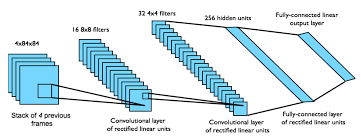

We refer to this type of CNN as *Deep Q-Networks*.

## <a id="xpr"></a>Experience replay

It is known that learning directly from consecutive samples is inefficient. The main reason is that these samples are strongly correlated with each other and learning sample by sample has the same risk of *catastrophic forgetting* that we already saw in Deep Learning. In other words, we risk forgetting about what was learned previously in some region of the state-action space, if we flood the Q-network with too many samples from another region.

In Deep Learning, this limitation was overcome by the introduction of mini-batches. Experience replay in Reinforcement Learning is a very similar approach that stores samples $(s,a,r,s')$ in a so-called *replay memory* $\mathcal{D}$ for $N$ time steps. Then, when updating the network's parameters, a mini-batch of $\mathcal{D}$ is uniformly sampled in order to compute the gradient.

Experience replay has three main advantages:
- Each sample $(s,a,r,s')$ can be reused in many updates (although this is not a N-step update, it allows a better usage of samples).
- Randomizing the mini-batch over the replay memory breaks the correlations between samples and thus reduces the variance of weights updates.
- The bias in exploration due to overestimating some Q-values (because of a tendency of neural networks to focus on the last samples) is reduced. Thus exploration is more efficient and we have less risk of getting stuck in local minima of the loss function.

<a href="#xp-replay" data-toggle="collapse"> Remarks</a><br>
<div id="xp-replay" class="collapse">
<ul>
<li> Our replay memory has finite length, we can still forget old samples. We have made our algorithm more robust but, yes, we still face catastrophic forgetting. For more refined approaches at remembering long term experience, see the usage of Recurrent Neural Networks in <a href="https://arxiv.org/pdf/1507.06527.pdf">this paper</a> for instance.
<li> The choice of uniform sampling within the replay memory is somehow a bit naive. We have seen in previous classes that the ordering of Bellman backups (in the model-based case) or TD updates (in the model-free case) have an importance in the convergence speed of the algorithm. Therefore, it would be beneficial to use a non-uniform distribution over samples in our experience replay procedure. This was developped in the <a href="https://arxiv.org/pdf/1511.05952.pdf">Prioritized Experience Replay</a> algorithm. That uses the TD error to approximate the Bellman residual and define update priorities.
<li> Experience replay *requires* an off-policy algorithm (thus it is not compatible with SARSA).
</ul>
</div>

### Reminder: the DQN algo
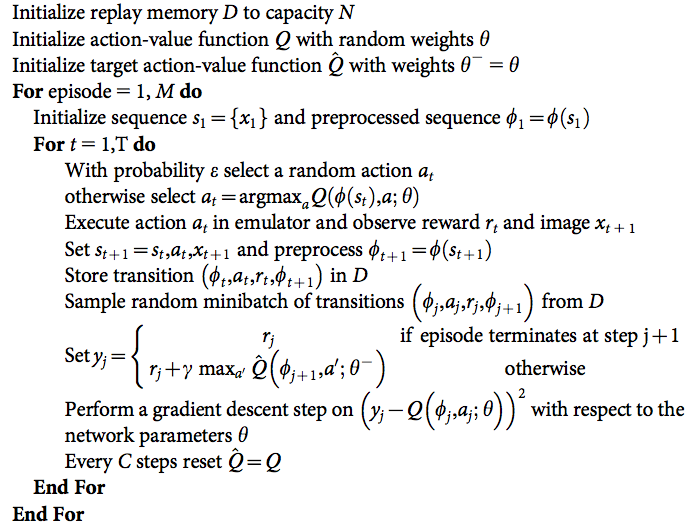

### Building the PacMan environment

In [20]:
env=gym.make("MsPacman-v0")
n_outputs=env.action_space.n
n_outputs

[2019-09-02 10:42:21,207] Making new env: MsPacman-v0


9

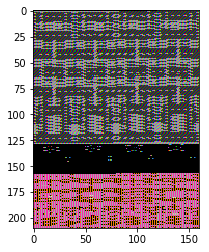

In [21]:
obs=env.reset()
plt.imshow(obs)
plt.show()

### Looking at the State Space

In [22]:
print(env.observation_space)
print(env.observation_space.shape)
print(np.min(env.observation_space.low))
print(np.max(env.observation_space.high))
print(env.action_space)

Box(210, 160, 3)
(210, 160, 3)
0.0
255.0
Discrete(9)


One frame is a $210\times 160$ RGB image with a 256 color palette, so the set of all possible frames has size $256^{210 \times 160 \times 3} \sim 10^{242579}$. That's a little too many for an efficient enumeration. Even by converting the image to greyscale, downsampling to a $110\times 84$ and then cropping to a $84\times 84$ image to keep only the playing area (as we shall do a little later to slightly simplify the problem), that's still around $10^{16980}$ possible stages. So, definitely, this discrete problem is not suitable for complete enumeration.
That is why we use a neural network as a function approximation for estimating the value function.

### Preprocessing the input game screen

In [23]:
color=np.array([210, 164,74]).mean()

In [24]:
def preprocess_observation(obs):
    # Crop and resize the image
    img=obs[1:176:2,::2]
    # convert the image to greyscale
    img=img.mean(axis=2)
    # Improve image contrast
    img[img==color]=0
    # normalizing the image from -1 to +1
    img=(img-128)/128 -1
    return img.reshape(80,88,1)

### Building the Q_network

In [25]:
input_shape=(80,88,1)
def deep_Q_network(input_shape, name):
    dqn=Sequential(name=name)
    dqn.add(Conv2D(32,kernel_size=(8,8), strides=4,input_shape=input_shape,activation='relu'))
    dqn.add(Conv2D(64,kernel_size=(3,3), strides=1, activation='relu'))
    dqn.add(Flatten())
    dqn.add(Dense(128,activation='relu'))
    dqn.add(Dense(n_outputs, activation='linear'))
    weights=dqn.get_weights()
    return dqn, weights

In [26]:
# parameters
epsilon=0.5
eps_min=0.05
eps_max=1.0
eps_decay_steps=500000

### Epsilon-greedy policy

In [27]:
def epsilon_greedy(action, step):
    epsilon=max(eps_min, eps_max- (eps_max-eps_min)*step/eps_decay_steps)
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        return action

### Building the replay buffer

In [28]:
def sample_memories(exp_buffer,batch_size):
    perm_batch=np.random.permutation(len(exp_buffer))[:batch_size]
    # do a random permutation of integers from 0 to len(exp_buffer) and then takes a sample of length batch_size
    mem=np.array(exp_buffer)[perm_batch]
    # each experience has 5 parameters: observation, action, next_observation, reward, done
    return mem[:,0], mem[:,1], mem[:,2], mem[:,3], mem[:,4] 

### Function for reward clipping

In [29]:
def clip_reward(r):
    rr=0
    if r>0:
        rr=1
    if r<0:
        rr=-1
    return rr

In [30]:
# defining all the hyperparameters
num_episodes=250
batch_size=32
learning_rate=0.001
discount_factor=0.9
buffer_len=20000
exp_buffer=deque(maxlen=buffer_len)

# counter of transitions (steps)
global_step=0
# number of steps before starting to train the network
start_steps=100
# number of steps before updating the target network
copy_steps=10
 # number of steps between each training epoch 
steps_train=4 
logdir='logs'

# optimisation hyperparameters
optimizer=keras.optimizers.Adam()
training_loss=keras.losses.mse

In [31]:
# Building the main Q network and the target network
mainDQN, mainDQN_weights=deep_Q_network(input_shape, 'mainDQN')
targetDQN, targetDQN_weights=deep_Q_network(input_shape, 'targetDQN')
mainDQN.compile(optimizer=optimizer, loss=training_loss)

### Steps to implement the DQN algorithm

* Loop over the number of episodes
* Begin the episode by resetting the state & setting the episodic reward & loss to zero
* While the state is not terminal do:
* Feed the preprocessed current state to the mainQ network and take the argmax to get the greedy action. 
* Plug this action in the epsilon to select your current action
* Do a transition with the function env.step(action): 
    append this transition (state, action, next state, reward, done) to the replay buffer (pre_process the next states and clip the rewards)
* If the global step > start_step & global step modulo steps_train=0 do: 
    * sample of mini batch of transitions with the function sample_memories()
    * Reformat the states and next_states variables to have numpy arrays 
    * Compute the training targets (TD updates): $t=reward+\gamma*\max_{a' \in A} Q(s', a')*(1-done)$
    * Compute the predicted values of Q using the mainQ network, and update the prediction with the trainig fargets for the actions sampled
    * Train the MainQ network with the mse loss, by using the function 'model.compile' and 'model.fit'of keras
    https://www.tensorflow.org/beta/guide/keras/training_and_evaluation
* If the global_step modulo the copy_step=0, update the weights of the target network
* Pursue to the next transition by assigning the current state to the next state
* Add +1 to the global step
* update the episodic reward by adding the mean reward of the mini-batch of transitions

### Launching the DQN

In [54]:
global_step=0
epoch=0
episode_rewards=[]
# for each episode
for i in range(num_episodes):
    # reset the environment
    done=False
    obs=env.reset()
    episodic_reward=0
    actions_counter=Counter()
    episodic_loss=[] 
    # while the state is not the terminal state
    while not done:
        # get the pre_process game screen
        X_obs=preprocess_observation(obs)
        # feed the game screen and get the Q_values for each action
        X_train=X_obs.reshape((1,)+X_obs.shape)
        QX=mainDQN.predict(X_train)
        
        # get the action
        action=np.argmax(QX, axis=-1)
        actions_counter[str(action)]+=1
        
        # select the action using epsilon greedy policy
        action=epsilon_greedy(action, global_step)
        
        # perform the action and move to the next step
        next_obs, reward, done,_=env.step(action)
        # store the transition as an experience in the replay buffer
        
        exp_buffer.append([X_obs,action,preprocess_observation(next_obs),clip_reward(reward),done])

        # after certain steps, we train the Q_network with samples from the experience replay buffer
        if global_step % steps_train==0 and global_step > start_steps:
            epoch=epoch+1
            
            # sample experiences
            states, actions, next_states, r, D=sample_memories(exp_buffer,batch_size)
            # reformat states and next_states
            states=np.array([state for state in states])
            # get next_states
            next_states=np.array([s for s in next_states])
            
            # compute the Training targets = TD update
            QY=targetDQN.predict(next_states)
            QYmax=np.max(QY,axis=-1)
            targets=r+ discount_factor*QYmax*(1-D)
            
            # Calcul predicted Q values
            QX=mainDQN.predict(states)
            for i,a in enumerate(actions):
                QX[i,a]=targets[i]

            #Compute the loss value for this minibatch.
            mainDQN.fit(x=states, y=QX)
            
            updated_weights=mainDQN.get_weights() # to change in save and upload weights
            
            episodic_reward+=np.mean(r)
            print('Epoch:{}'.format(epoch),'loss:{}'.format(training_loss))

        #After a certain number of steps, copy the update with target network with the updated_weights
        if global_step % copy_steps==0 and global_step > start_steps:
            targetDQN.set_weights(updated_weights)

        obs=next_obs
        global_step+=1
        
    episode_rewards.append(episodic_reward)
        
    print('end of episode with {} actions...'.format(sum(actions_counter.values())), 'episodic reward:{}'.format(episodic_reward))

Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch:1 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0071
Epoch:2 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0050
Epoch:3 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0050
Epoch:4 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch:5 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch:6 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0047
Epoch:7 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==========

Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch:60 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0050
Epoch:61 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch:62 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch:63 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 9.5739e-04
Epoch:64 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0058
Epoch:65 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0052
Epoch:66 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 

48/48 [==============================] - 0s 2ms/step - loss: 0.0193
Epoch:118 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 5.8860e-04
Epoch:119 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch:120 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch:121 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0049
Epoch:122 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch:123 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch:124 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==

Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0070
Epoch:176 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0048
Epoch:177 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch:178 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0246
Epoch:179 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0056
Epoch:180 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0203
Epoch:181 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch:182 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/

Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch:234 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch:235 loss:<function mean_squared_error at 0x7f3379ee3d90>
end of episode with 1044 actions episodic reward:7.479166666666663
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch:236 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch:237 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0074
Epoch:238 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0033
Epoch:239 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch:240

48/48 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch:291 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0062
Epoch:292 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch:293 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch:294 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 6.3419e-04
Epoch:295 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0067
Epoch:296 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch:297 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==

Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0047
Epoch:349 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch:350 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch:351 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0070
Epoch:352 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch:353 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0051
Epoch:354 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch:355 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/

48/48 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch:406 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 7.2695e-04
Epoch:407 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch:408 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0039
Epoch:409 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0052
Epoch:410 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0049
Epoch:411 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 5.0223e-04
Epoch:412 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48

Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0047
Epoch:464 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch:465 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0064
Epoch:466 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0039
Epoch:467 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0245
Epoch:468 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0033
Epoch:469 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0050
Epoch:470 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/

Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0059
Epoch:522 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0076
Epoch:523 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch:524 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0049
Epoch:525 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 1.5873e-04
Epoch:526 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch:527 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0100
Epoch:528 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1

48/48 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch:579 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0267
Epoch:580 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 3.9279e-04
Epoch:581 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0069
Epoch:582 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 5.6534e-04
Epoch:583 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch:584 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch:585 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48

Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0073
Epoch:637 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0076
Epoch:638 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch:639 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0257
Epoch:640 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0056
Epoch:641 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0060
Epoch:642 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0060
Epoch:643 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/

48/48 [==============================] - 0s 2ms/step - loss: 0.0058
Epoch:694 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch:695 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 9.9983e-04
Epoch:696 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 9.8449e-04
Epoch:697 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch:698 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch:699 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch:700 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48

48/48 [==============================] - 0s 2ms/step - loss: 0.0050
Epoch:752 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch:753 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 5.0615e-04
Epoch:754 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch:755 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch:756 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0044
Epoch:757 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch:758 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==

Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0046
Epoch:810 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0060
Epoch:811 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0055
Epoch:812 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 8.8010e-04
Epoch:813 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch:814 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0080
Epoch:815 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch:816 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1

48/48 [==============================] - 0s 2ms/step - loss: 0.0350
Epoch:867 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0626
Epoch:868 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0535
Epoch:869 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0357
Epoch:870 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0299
Epoch:871 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0158
Epoch:872 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0072
Epoch:873 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [======

48/48 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch:925 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch:926 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch:927 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 5.4296e-04
Epoch:928 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch:929 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch:930 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0049
Epoch:931 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==

Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0047
Epoch:983 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch:984 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch:985 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch:986 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch:987 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0064
Epoch:988 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch:989 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/

48/48 [==============================] - 0s 2ms/step - loss: 0.0048
Epoch:1040 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch:1041 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch:1042 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch:1043 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0066
Epoch:1044 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 4.7211e-04
Epoch:1045 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch:1046 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48

48/48 [==============================] - 0s 2ms/step - loss: 0.0046
Epoch:1097 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch:1098 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0046
Epoch:1099 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch:1100 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch:1101 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0047
Epoch:1102 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0046
Epoch:1103 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 

Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0249
Epoch:1155 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0254
Epoch:1156 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0069
Epoch:1157 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0041
Epoch:1158 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0305
Epoch:1159 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch:1160 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch:1161 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 

Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0250
Epoch:1212 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch:1213 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch:1214 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0225
Epoch:1215 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0054
Epoch:1216 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 3.6287e-04
Epoch:1217 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch:1218 loss:<function mean_squared_error at 0x7f3379ee3d90>
Ep

Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0048
Epoch:1270 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch:1271 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0305
Epoch:1272 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch:1273 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0046
Epoch:1274 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch:1275 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0072
Epoch:1276 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 

48/48 [==============================] - 0s 2ms/step - loss: 1.7501e-04
Epoch:1327 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch:1328 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch:1329 loss:<function mean_squared_error at 0x7f3379ee3d90>
end of episode with 657 actions episodic reward:5.270833333333333
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch:1330 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 4.1191e-04
Epoch:1331 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch:1332 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch:

Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch:1384 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0070
Epoch:1385 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 7.9228e-04
Epoch:1386 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0068
Epoch:1387 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 4.9629e-04
Epoch:1388 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 2.5671e-04
Epoch:1389 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch:1390 loss:<function mean_squared_error at 0x7f3379ee

48/48 [==============================] - 0s 2ms/step - loss: 0.0049
Epoch:1441 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0042
Epoch:1442 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch:1443 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch:1444 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch:1445 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0074
Epoch:1446 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 5.7446e-04
Epoch:1447 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48

Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch:1498 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch:1499 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch:1500 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch:1501 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch:1502 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0235
Epoch:1503 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0054
Epoch:1504 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 

48/48 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch:1555 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0069
Epoch:1556 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0067
Epoch:1557 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0075
Epoch:1558 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0041
Epoch:1559 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0294
Epoch:1560 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0290
Epoch:1561 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 

Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0045
Epoch:1613 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 3ms/step - loss: 0.0069
Epoch:1614 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0048
Epoch:1615 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0046
Epoch:1616 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch:1617 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0047
Epoch:1618 loss:<function mean_squared_error at 0x7f3379ee3d90>
end of episode with 603 actions episodic reward:5.604166666666666
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 3.5621e-04


Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 2.3966e-04
Epoch:1670 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0064
Epoch:1671 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0049
Epoch:1672 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 3.1670e-04
Epoch:1673 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch:1674 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch:1675 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch:1676 loss:<function mean_squared_error at 0x7f3379ee3d90

48/48 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch:1727 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch:1728 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0063
Epoch:1729 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 7.6592e-04
Epoch:1730 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0047
Epoch:1731 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0204
Epoch:1732 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch:1733 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48

48/48 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch:1784 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch:1785 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0058
Epoch:1786 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0057
Epoch:1787 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0057
Epoch:1788 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch:1789 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0074
Epoch:1790 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 

Epoch:1841 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0073
Epoch:1842 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch:1843 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch:1844 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch:1845 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0210
Epoch:1846 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0056
Epoch:1847 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0297
Epoch:

48/48 [==============================] - 0s 3ms/step - loss: 0.0029
Epoch:1899 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch:1900 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0150
Epoch:1901 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch:1902 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0072
Epoch:1903 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch:1904 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 4.7407e-04
Epoch:1905 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48

48/48 [==============================] - 0s 2ms/step - loss: 0.0178
Epoch:1956 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0069
Epoch:1957 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch:1958 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0042
Epoch:1959 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0072
Epoch:1960 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0108
Epoch:1961 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0101
Epoch:1962 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 

Epoch:2013 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0058
Epoch:2014 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 8.3881e-04
Epoch:2015 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0064
Epoch:2016 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch:2017 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0052
Epoch:2018 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0050
Epoch:2019 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0075
Ep

48/48 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch:2071 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch:2072 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0246
Epoch:2073 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0255
Epoch:2074 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch:2075 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch:2076 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0060
Epoch:2077 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 

48/48 [==============================] - 0s 2ms/step - loss: 0.0265
Epoch:2128 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch:2129 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 7.9354e-04
Epoch:2130 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch:2131 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch:2132 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch:2133 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 3.5241e-04
Epoch:2134 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/

48/48 [==============================] - 0s 2ms/step - loss: 0.0203
Epoch:2185 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0033
Epoch:2186 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch:2187 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 4.5874e-04
Epoch:2188 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch:2189 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 2.1233e-04
Epoch:2190 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch:2191 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/

48/48 [==============================] - 0s 2ms/step - loss: 2.9180e-04
Epoch:2242 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch:2243 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch:2244 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch:2245 loss:<function mean_squared_error at 0x7f3379ee3d90>
end of episode with 549 actions episodic reward:4.791666666666666
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0045
Epoch:2246 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch:2247 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 1.9775e-04
Epoch:

Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0051
Epoch:2299 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch:2300 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0104
Epoch:2301 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0069
Epoch:2302 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch:2303 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 8.5512e-04
Epoch:2304 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch:2305 loss:<function mean_squared_error at 0x7f3379ee3d90>
Ep

48/48 [==============================] - 0s 2ms/step - loss: 0.0040
Epoch:2356 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0041
Epoch:2357 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0071
Epoch:2358 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 8.5060e-04
Epoch:2359 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0067
Epoch:2360 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0073
Epoch:2361 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch:2362 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48

Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0054
Epoch:2414 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch:2415 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 3.2702e-04
Epoch:2416 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 2.5064e-04
Epoch:2417 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch:2418 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0045
Epoch:2419 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch:2420 loss:<function mean_squared_error at 0x7f3379ee3d90

Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 2.0520e-04
Epoch:2471 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0067
Epoch:2472 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0047
Epoch:2473 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0050
Epoch:2474 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch:2475 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0054
Epoch:2476 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0036
Epoch:2477 loss:<function mean_squared_error at 0x7f3379ee3d90>
Ep

48/48 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch:2529 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 5.2822e-04
Epoch:2530 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 3ms/step - loss: 4.3453e-04
Epoch:2531 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch:2532 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0063
Epoch:2533 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 2.8131e-04
Epoch:2534 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch:2535 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoc

48/48 [==============================] - 0s 2ms/step - loss: 0.0047
Epoch:2586 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch:2587 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch:2588 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 3ms/step - loss: 0.0066
Epoch:2589 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch:2590 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0101
Epoch:2591 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 3.7874e-04
Epoch:2592 loss:<function mean_squared_error at 0x7f3379ee3d90>
end of episo

48/48 [==============================] - 0s 2ms/step - loss: 0.0045
Epoch:2643 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch:2644 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch:2645 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch:2646 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0048
Epoch:2647 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 6.5550e-04
Epoch:2648 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 3.6859e-04
Epoch:2649 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/

48/48 [==============================] - 0s 2ms/step - loss: 0.0068
Epoch:2700 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0065
Epoch:2701 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch:2702 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0111
Epoch:2703 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0045
Epoch:2704 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 2.2641e-04
Epoch:2705 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch:2706 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48

48/48 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch:2757 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0293
Epoch:2758 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0047
Epoch:2759 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0044
Epoch:2760 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0046
Epoch:2761 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch:2762 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 6.3412e-04
Epoch:2763 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48

48/48 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch:2814 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch:2815 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch:2816 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch:2817 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0049
Epoch:2818 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0044
Epoch:2819 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch:2820 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 

Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0051
Epoch:2871 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0075
Epoch:2872 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0043
Epoch:2873 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0048
Epoch:2874 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch:2875 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 3.4322e-04
Epoch:2876 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch:2877 loss:<function mean_squared_error at 0x7f3379ee3d90>
Ep

48/48 [==============================] - 0s 2ms/step - loss: 1.7060e-04
Epoch:2928 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0046
Epoch:2929 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0178
Epoch:2930 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch:2931 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0066
Epoch:2932 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0064
Epoch:2933 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch:2934 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48

48/48 [==============================] - 0s 2ms/step - loss: 8.9543e-04
Epoch:2985 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch:2986 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 9.2231e-04
Epoch:2987 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0073
Epoch:2988 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0051
Epoch:2989 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch:2990 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch:2991 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/

48/48 [==============================] - 0s 2ms/step - loss: 0.0052
Epoch:3042 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch:3043 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 3.4251e-04
Epoch:3044 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch:3045 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 2.5105e-04
Epoch:3046 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 3.9887e-04
Epoch:3047 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0066
Epoch:3048 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoc

48/48 [==============================] - 0s 2ms/step - loss: 0.0068
Epoch:3099 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 8.2241e-04
Epoch:3100 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch:3101 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0220
Epoch:3102 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch:3103 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch:3104 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0074
Epoch:3105 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48

48/48 [==============================] - 0s 2ms/step - loss: 2.6581e-04
Epoch:3156 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0045
Epoch:3157 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch:3158 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0045
Epoch:3159 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch:3160 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch:3161 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0069
Epoch:3162 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48

48/48 [==============================] - 0s 2ms/step - loss: 0.0074
Epoch:3213 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0046
Epoch:3214 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0214
Epoch:3215 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch:3216 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0079
Epoch:3217 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0036
Epoch:3218 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch:3219 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 

Epoch 1/1
48/48 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch:3271 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch:3272 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0049
Epoch:3273 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0051
Epoch:3274 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0072
Epoch:3275 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 3ms/step - loss: 0.0090
Epoch:3276 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch:3277 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 

Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch:3329 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch:3330 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 6.9747e-04
Epoch:3331 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch:3332 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 2.6531e-04
Epoch:3333 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch:3334 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0049
Epoch:3335 loss:<function mean_squared_error at 0x7f3379ee3d90

48/48 [==============================] - 0s 2ms/step - loss: 0.0041
Epoch:3386 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch:3387 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 9.5819e-04
Epoch:3388 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch:3389 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0047
Epoch:3390 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0072
Epoch:3391 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch:3392 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48

48/48 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch:3443 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0062
Epoch:3444 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0113
Epoch:3445 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0049
Epoch:3446 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0047
Epoch:3447 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch:3448 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0054
Epoch:3449 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 

Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch:3501 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0079
Epoch:3502 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 3ms/step - loss: 0.0095
Epoch:3503 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch:3504 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 3ms/step - loss: 8.3967e-04
Epoch:3505 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 8.7733e-04
Epoch:3506 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 3ms/step - loss: 5.9276e-04
Epoch:3507 loss:<function mean_squared_error at 0x7f3379ee

48/48 [==============================] - 0s 2ms/step - loss: 5.6491e-04
Epoch:3558 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 3ms/step - loss: 0.0022
Epoch:3559 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 3ms/step - loss: 0.0025
Epoch:3560 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch:3561 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 3ms/step - loss: 1.8089e-04
Epoch:3562 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch:3563 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch:3564 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/

48/48 [==============================] - 0s 2ms/step - loss: 0.0041
Epoch:3615 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0033
Epoch:3616 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0074
Epoch:3617 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch:3618 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0071
Epoch:3619 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0229
Epoch:3620 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 5.4252e-04
Epoch:3621 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48

Epoch:3672 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch:3673 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 3ms/step - loss: 0.0066
Epoch:3674 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 3ms/step - loss: 3.3876e-04
Epoch:3675 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0064
Epoch:3676 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch:3677 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 3ms/step - loss: 0.0028
Epoch:3678 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0074
Ep

Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0149
Epoch:3730 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 6.8769e-04
Epoch:3731 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 4.3008e-04
Epoch:3732 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0045
Epoch:3733 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 5.3696e-04
Epoch:3734 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 3.6383e-04
Epoch:3735 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0047
Epoch:3736 loss:<function mean_squared_error at 0x7f33

Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 2.7813e-04
Epoch:3787 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 1.7542e-04
Epoch:3788 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 3ms/step - loss: 0.0025
Epoch:3789 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch:3790 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0070
Epoch:3791 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0052
Epoch:3792 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 3ms/step - loss: 0.0029
Epoch:3793 loss:<function mean_squared_error at 0x7f3379ee3d90

48/48 [==============================] - 0s 2ms/step - loss: 0.0061
Epoch:3844 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0041
Epoch:3845 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch:3846 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch:3847 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch:3848 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch:3849 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 9.2556e-04
Epoch:3850 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48

Epoch:3901 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch:3902 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 5.7979e-04
Epoch:3903 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch:3904 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch:3905 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch:3906 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch:3907 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 3.0413e-0

48/48 [==============================] - 0s 3ms/step - loss: 0.0027
Epoch:3958 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 3ms/step - loss: 5.2659e-04
Epoch:3959 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0209
Epoch:3960 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 3ms/step - loss: 0.0076
Epoch:3961 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0046
Epoch:3962 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch:3963 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 3ms/step - loss: 0.0199
Epoch:3964 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48

48/48 [==============================] - 0s 2ms/step - loss: 3.5582e-04
Epoch:4015 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 2.5595e-04
Epoch:4016 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 2.5095e-04
Epoch:4017 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch:4018 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0048
Epoch:4019 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch:4020 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0045
Epoch:4021 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoc

48/48 [==============================] - 0s 2ms/step - loss: 0.0043
Epoch:4072 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 2.0008e-04
Epoch:4073 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 2.1335e-04
Epoch:4074 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 1.4760e-04
Epoch:4075 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0049
Epoch:4076 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch:4077 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0109
Epoch:4078 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoc

48/48 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch:4129 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch:4130 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0048
Epoch:4131 loss:<function mean_squared_error at 0x7f3379ee3d90>
end of episode with 833 actions episodic reward:6.395833333333334
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch:4132 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch:4133 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0214
Epoch:4134 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch:4135 los

48/48 [==============================] - 0s 2ms/step - loss: 0.0069
Epoch:4186 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch:4187 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0065
Epoch:4188 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch:4189 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch:4190 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 0.0069
Epoch:4191 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48/48 [==============================] - 0s 2ms/step - loss: 3.0346e-04
Epoch:4192 loss:<function mean_squared_error at 0x7f3379ee3d90>
Epoch 1/1
48

KeyboardInterrupt: 

### Plotting the evolution of the episodic reward

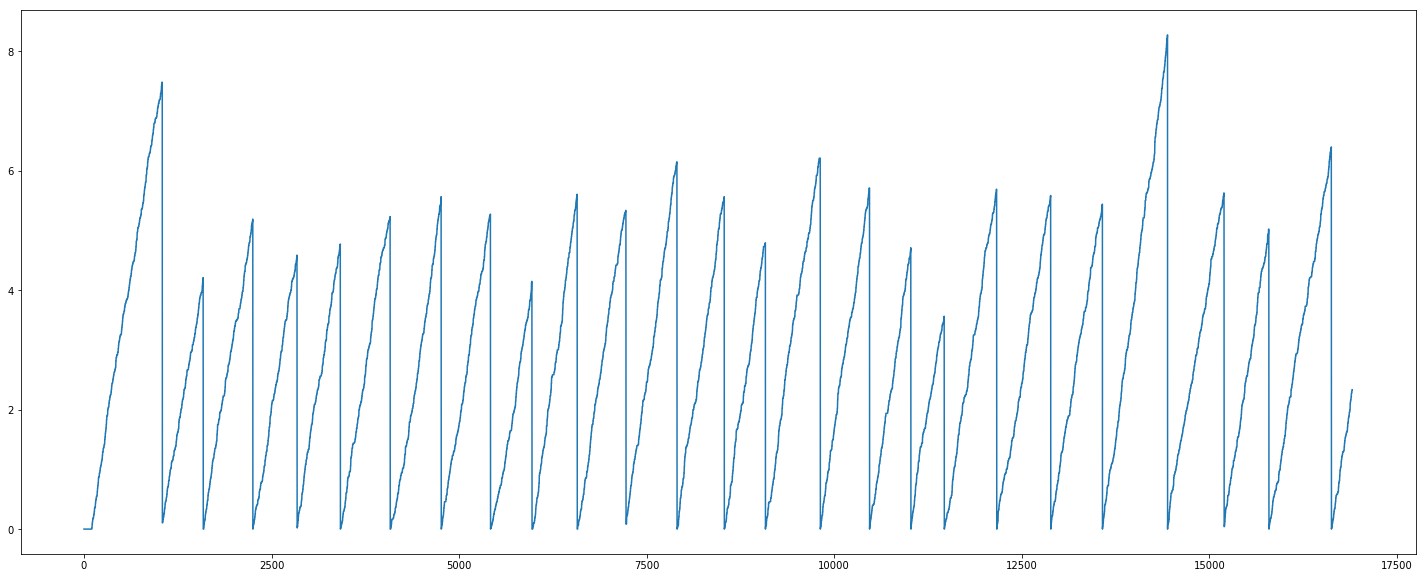

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline
fig=plt.figure(figsize=(25,10))
plt.plot(episode_rewards)